# Цифровые фильтры

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt 

print('Init')

Init


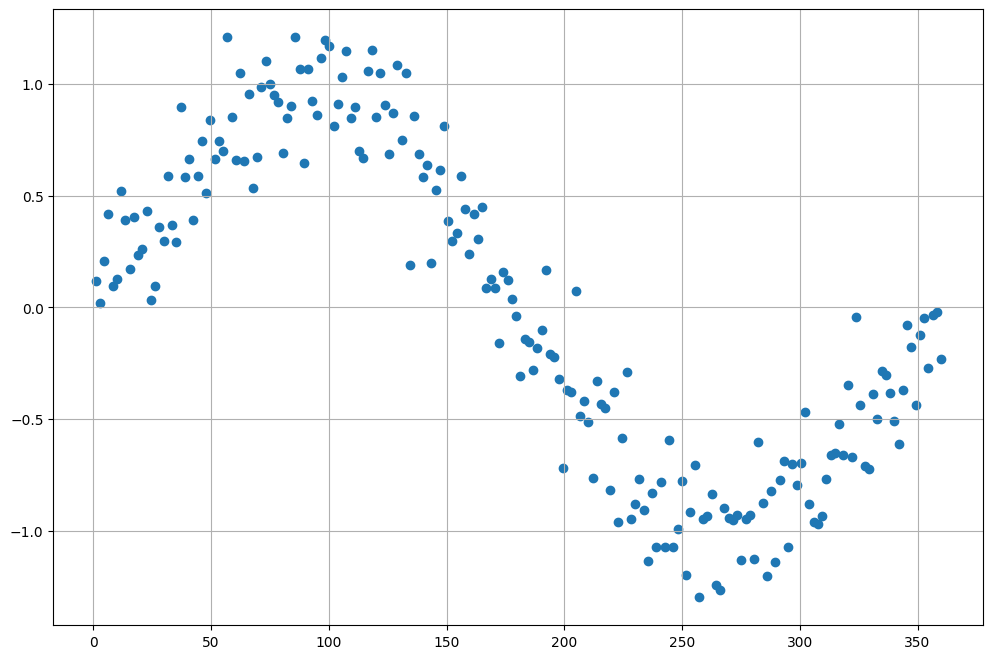

In [13]:
N = 200
alpha = 0.2
np.random.seed(42)

df = pd.DataFrame()
## создаём 360 точек для оси времени
df['t'] = np.linspace(1, 360, N)
## cтроим синус на этих точках
df['y'] = np.sin(df.t * np.pi / 180)
## добавляем шум в данные
df['y'] = df.y + alpha*np.random.randn(N)

## визуализируем ряд
f, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df.t, df.y)
ax.grid()

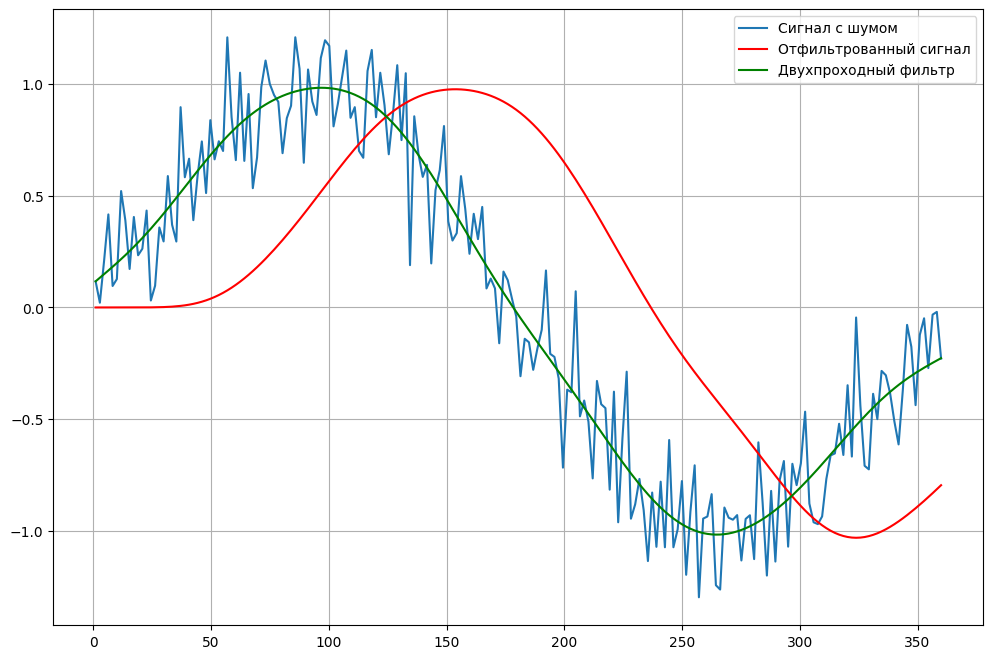

In [14]:
from scipy import signal

## создаём фильтр ("фильтр Баттерворта")
b, a = signal.butter(8, 0.05)
## применяем его
df['y_filt'] = signal.lfilter(b, a, df.y)
df['y_filt_double'] = signal.filtfilt(b, a, df.y, padlen=150)

f, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.t, df.y)
ax.plot(df.t, df.y_filt, 'r')
ax.plot(df.t, df.y_filt_double, 'g')
ax.legend(['Сигнал с шумом', 'Отфильтрованный сигнал', 'Двуxпроходный фильтр'])
ax.grid()

# Преобразование Фурье

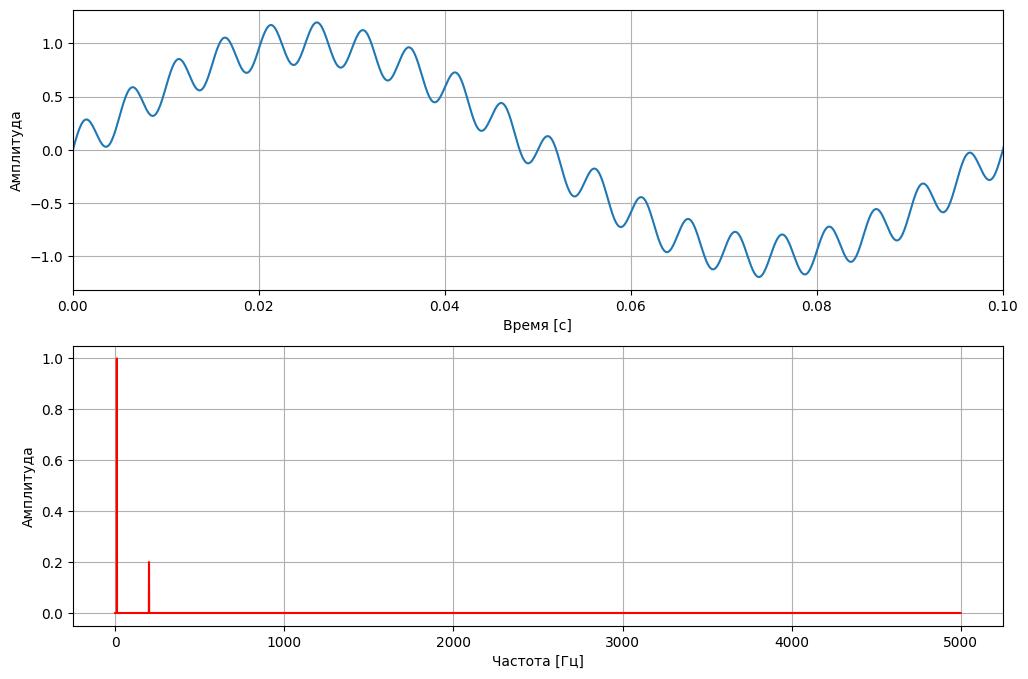

In [4]:
import matplotlib.pyplot as plt
import numpy as np

w1 = 10   ## частота первого синуса: 10 Гц
w2 = 200  ## частота второго синуса: 150 Гц
a1 = 1    ## амплитуда первого синуса
a2 = 0.2  ## амплитуда второго синуса
Fs = 10000  ## частота дискретизации: 10 кГц
Ts = 1.0/Fs ## интервал времени между соседними точками

df = pd.DataFrame()
## ось времени
df['t'] = np.arange(0, 1, Ts)
## cигнал
df['y'] = a1*np.sin(2*np.pi*w1*df.t) + a2*np.sin(2*np.pi*w2*df.t) 

N = len(df)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
frq = frq[range(int(N/2))]

## делаем преобразование Фурье
Y = 2/N * np.fft.fft(df.y)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
Y = Y[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df.t, df.y)
ax[0].set_xlim([0, 0.1])
ax[0].set_xlabel('Время [c]')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r') 
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
# ax[1].set_xlim([-200, 200])
ax[1].grid()

data = df.copy()

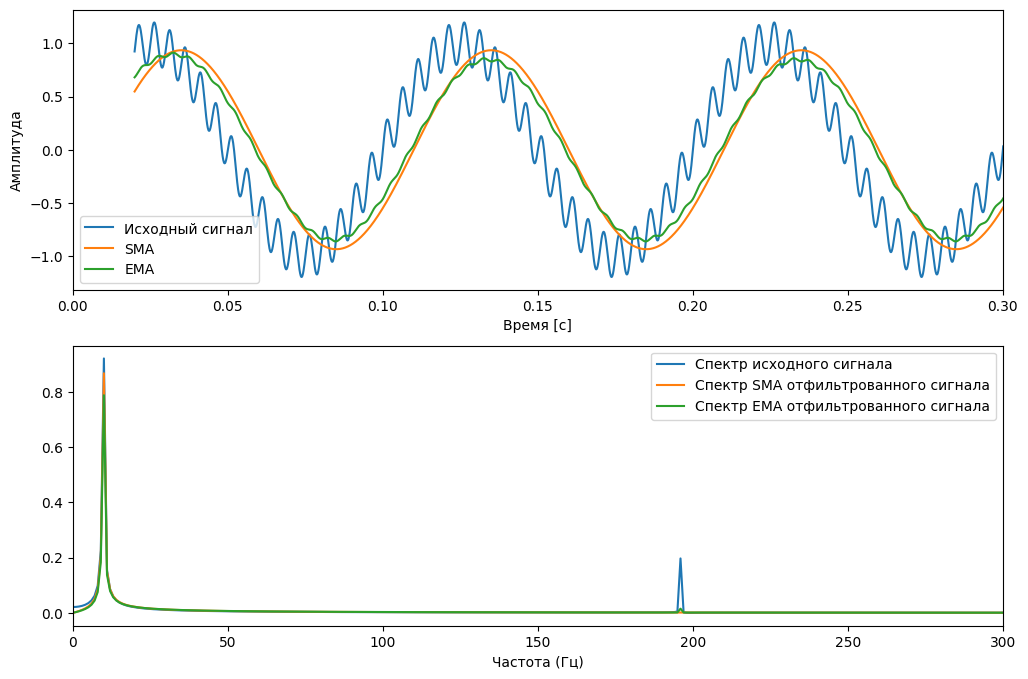

In [5]:
df = data.copy()

K = 200
## делаем оконное среднее с окном в K точек
df['rolling_mean_' + str(K)] = df.y.rolling(window=K).mean()
## экспоненциально среднее с окном в K точек
# df['rolling_ema_' + str(K)] = df.y.ewm(min_periods=K, span=K).mean()
df['rolling_ema_' + str(K)] = df.y.ewm(min_periods=K, alpha=0.01).mean()

## FFT не работает с пропущенными данными
df = df.dropna()

Y = 2/N * np.fft.fft(df.y)[range(int(N/2))]
Y_sma = 2/N * np.fft.fft(df['rolling_mean_' + str(K)])[range(int(N/2))]
Y_ema = 2/N * np.fft.fft(df['rolling_ema_' + str(K)])[range(int(N/2))]

frq = np.fft.fftfreq(N, Ts)[range(int(N/2))]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df.t, df.y)
ax[0].plot(df.t, df['rolling_mean_' + str(K)])
ax[0].plot(df.t, df['rolling_ema_' + str(K)])
ax[0].legend(['Исходный сигнал', 'SMA', 'EMA'])
ax[0].set_xlim([0, 0.3])
ax[0].set_xlabel('Время [c]')
ax[0].set_ylabel('Амплитуда')

ax[1].plot(frq, abs(Y)) 
ax[1].plot(frq, abs(Y_sma)) 
ax[1].plot(frq, abs(Y_ema)) 
ax[1].set_xlim([0, 300])
ax[1].set_xlabel('Частота (Гц)')
ax[1].legend(['Спектр исходного сигнала', 'Спектр SMA отфильтрованного сигнала', 'Спектр EMA отфильтрованного сигнала'])
plt.show()

Подавление сигнала на частоте 200 Гц: -32.5 дБ  (в 42.2 раз)


C:\Users\pavlu\AppData\Local\Temp\ipykernel_159348\250965213.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(w, 20 * np.log10(abs(h)))


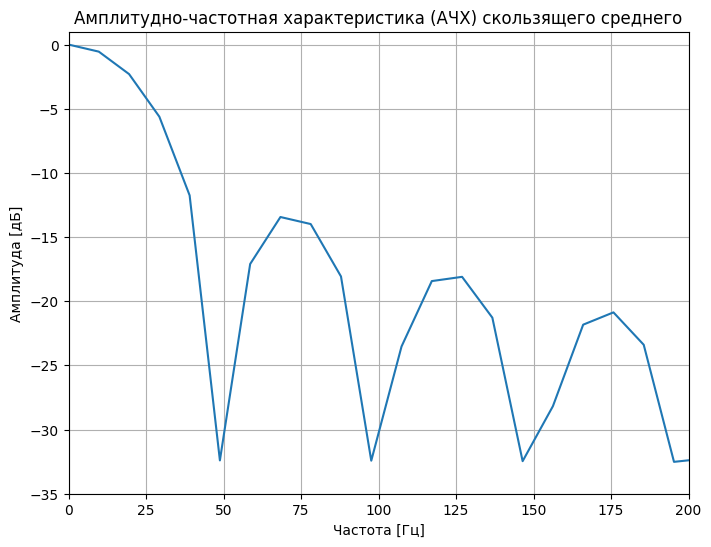

In [6]:
from scipy import signal
b = [1 / K] * K
w, h = signal.freqz(b, 1)
w = Fs/np.pi/2 * w

## график Боде
f, ax = plt.subplots(figsize=(8, 6))
ax.plot(w, 20 * np.log10(abs(h)))
ax.set_ylabel('Амплитуда [дБ]')
ax.set_xlim([0, 200])
ax.set_ylim([-35, 1])
ax.set_xlabel('Частота [Гц]')
ax.set_title('Амплитудно-частотная характеристика (АЧХ) скользящего среднего')
ax.grid()

ind = np.where((w > w2-5) & (w < w2+5))[0][0]
print(f'Подавление сигнала на частоте {w2} Гц: {20 * np.log10(abs(h[ind])):.1f} дБ  (в {1/abs(h[ind]):0.1f} раз)')

Подавление сигнала на частоте 200 Гц: -21.8 дБ  (в 12.3 раз)


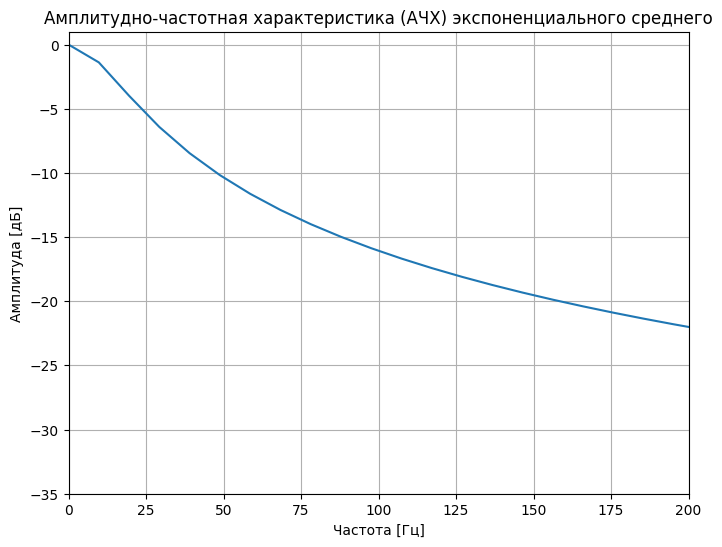

In [7]:
alpha = 2 / (K+1)
# https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Digital-filters/Exponential%20Moving%20Average/Exponential-Moving-Average.html
b = np.array(alpha)
a = np.array((1, alpha - 1))

## получить частотную характеристику фильтра
w, h = signal.freqz(b, a)
w = Fs/np.pi/2 * w ## переводим радианы в Герцы

f, ax = plt.subplots(figsize=(8, 6))
ax.plot(w, 20 * np.log10(abs(h)))
ax.set_xlim([0, 200])
ax.set_ylim([-35, 1])
ax.set_ylabel('Амплитуда [дБ]')
ax.set_xlabel('Частота [Гц]')
ax.set_title('Амплитудно-частотная характеристика (АЧХ) экспоненциального среднего')
ax.grid()

ind = np.where((w > w2-5) & (w < w2+5))[0][0]
print(f'Подавление сигнала на частоте {w2} Гц: {20 * np.log10(abs(h[ind])):.1f} дБ  (в {1/abs(h[ind]):0.1f} раз)')

# Полосо-пропускающие и полосо-заграждающие фильтры

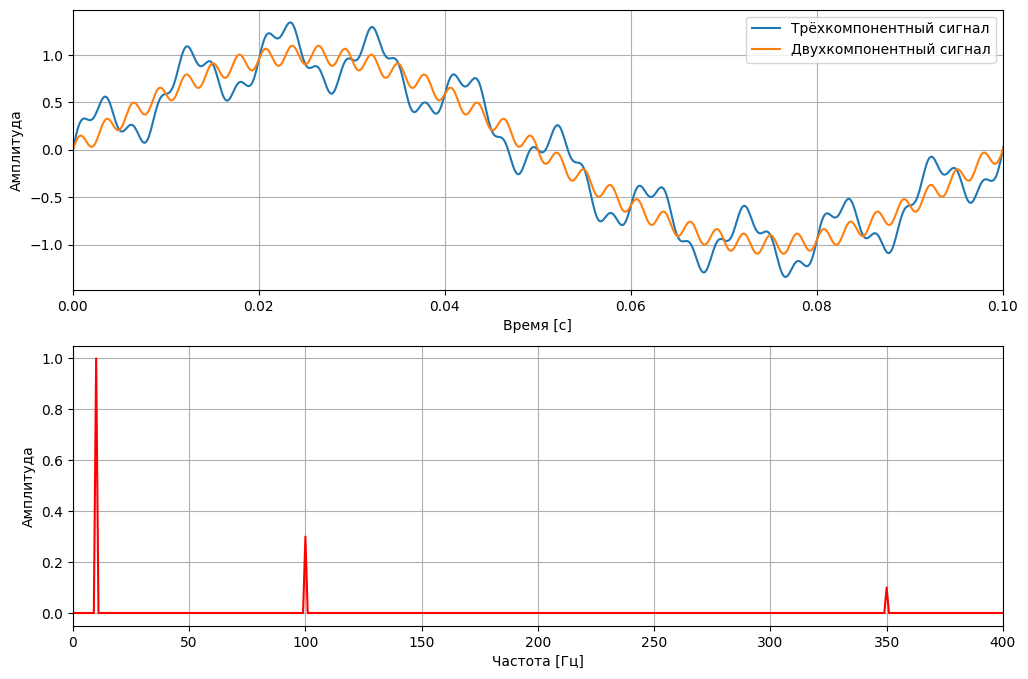

In [8]:
w1 = 10  ## частота первого синуса
w2 = 100  ## частота второго синуса
w3 = 350
a1 = 1    ## амплитуда первого синуса
a2 = 0.3  ## амплитуда второго синуса
a3 = 0.1
Fs = 10000  ## частота дискретизации
Ts = 1.0/Fs ## интервал времени между соседними точками

df = pd.DataFrame()
## ось времени
df['t'] = np.arange(0, 1, Ts)
## cигнал из трёх компонент
df['y'] = a1*np.sin(2*np.pi*w1*df.t) + a2*np.sin(2*np.pi*w2*df.t) + a3*np.sin(2*np.pi*w3*df.t)

## желаемый сигнал (из первой и третьей компоненты)
df['y_desired'] = a1*np.sin(2*np.pi*w1*df.t) + a3*np.sin(2*np.pi*w3*df.t)

N = len(df)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
frq = frq[range(int(N/2))]

## делаем преобразование Фурье
Y = 2/N * np.fft.fft(df.y)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
Y = Y[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df.t, df.y)
ax[0].plot(df.t, df.y_desired)
ax[0].legend(['Трёхкомпонентный сигнал', 'Двухкомпонентный сигнал'])
ax[0].set_xlim([0, 0.1])
ax[0].set_xlabel('Время [c]')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r') 
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
ax[1].set_xlim([0, 400])
ax[1].grid()

data = df.copy()

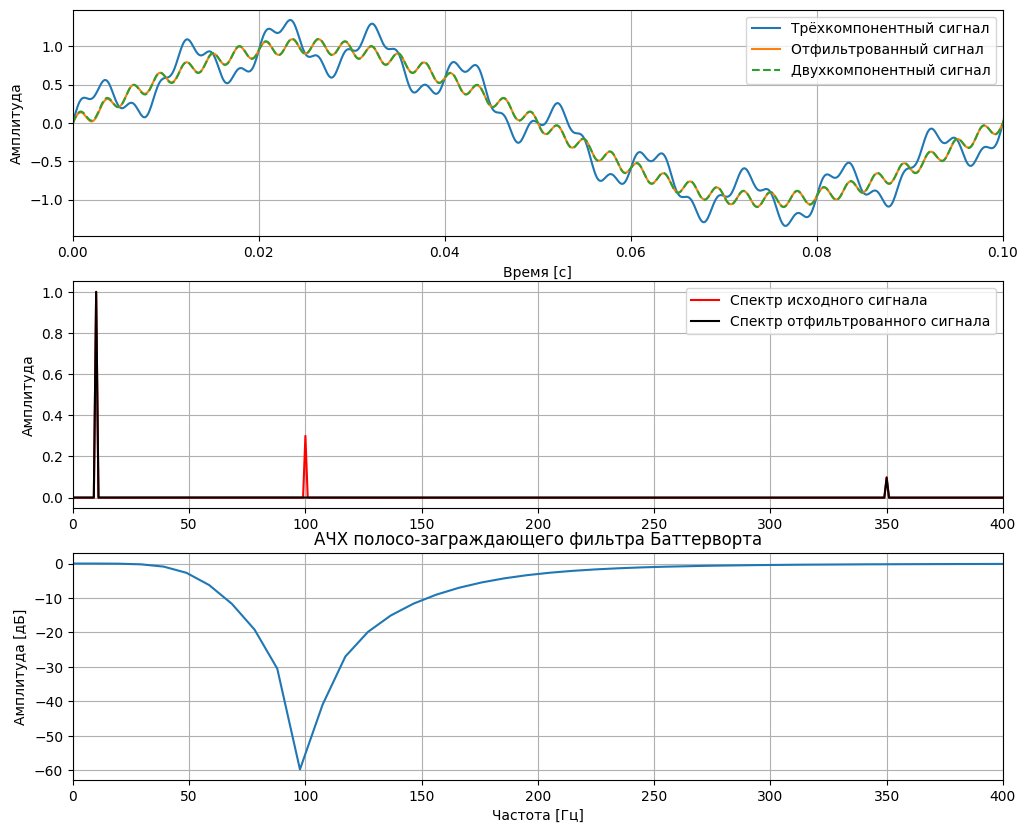

In [9]:
## полосо-заграждающий фильтр
b, a = signal.butter(2, [50, 200], btype='bandstop', fs=Fs)
df['y_filt'] = signal.filtfilt(b, a, df.y)

## АЧХ фильтра
w, h = signal.freqz(b, a)
w = Fs/np.pi/2 * w ## переводим радианы в Герцы

N = len(df)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)[range(int(N/2))]

## делаем преобразование Фурье
Y_filt = 2/N * np.fft.fft(df.y_filt)[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].plot(df.t, df.y)
ax[0].plot(df.t, df.y_filt)
ax[0].plot(df.t, df.y_desired, '--')
ax[0].legend(['Трёхкомпонентный сигнал', 'Отфильтрованный сигнал', 'Двухкомпонентный сигнал'])
ax[0].set_xlim([0, 0.1])
ax[0].set_xlabel('Время [c]')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r')
ax[1].plot(frq, abs(Y_filt), c='k') 
ax[1].legend(['Спектр исходного сигнала', 'Спектр отфильтрованного сигнала'])
# ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
ax[1].set_xlim([0, 400])
ax[1].grid()

ax[2].plot(w, 20 * np.log10(abs(h)))
ax[2].set_xlim([0, 400])
# ax[2].set_ylim([-35, 1])
ax[2].set_ylabel('Амплитуда [дБ]')
ax[2].set_xlabel('Частота [Гц]')
ax[2].set_title('АЧХ полосо-заграждающего фильтра Баттерворта')
ax[2].grid()

# Пример непрерывного Фурье спектра

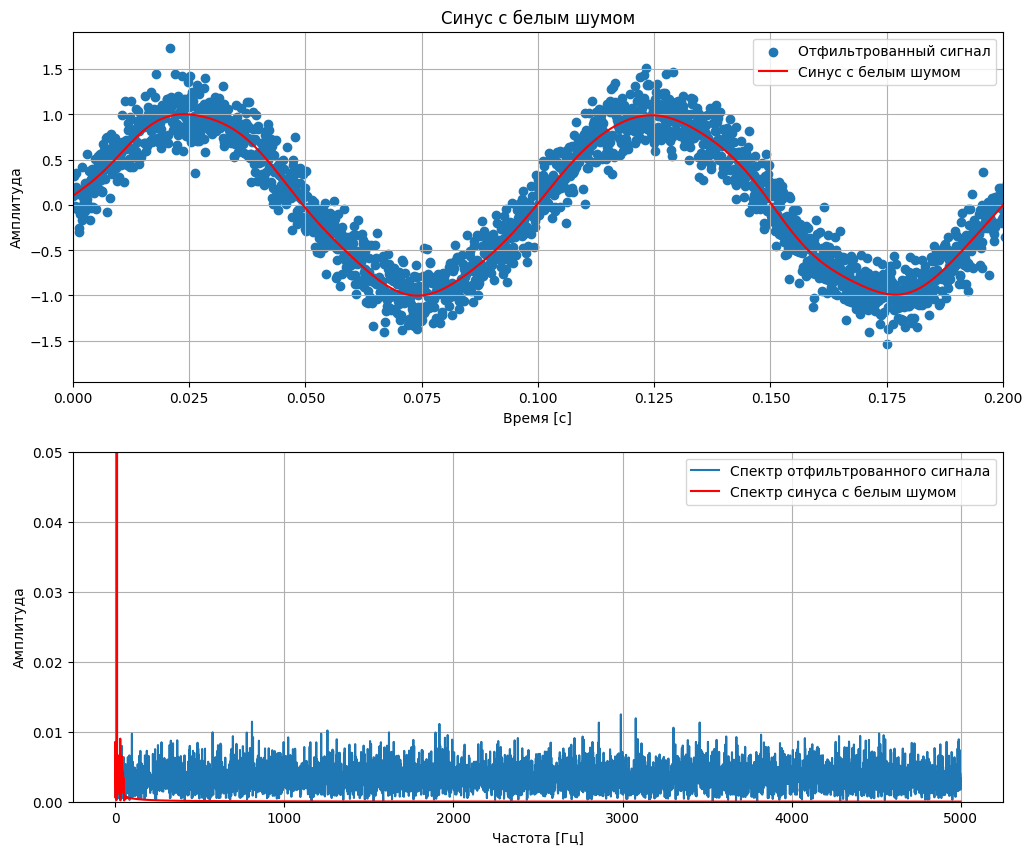

In [10]:
w1 = 10  ## частота синуса
a1 = 1   ## амплитуда синуса
alpha = 0.2 ## амплитуда шума
Fs = 10000  ## частота дискретизации
Ts = 1.0/Fs ## интервал времени между соседними точками

df = pd.DataFrame()
## ось времени
df['t'] = np.arange(0, 1, Ts)
## cигнал из трёх компонент
df['y'] = a1*np.sin(2*np.pi*w1*df.t)

N = len(df) 
np.random.seed(42)
## добавляем шум в данные
df['y'] = df.y + alpha*np.random.randn(N)


## создаём фильтр Баттерворта
b, a = signal.butter(8, 0.01)
## применяем его
df['y_filt'] = signal.filtfilt(b, a, df.y, padlen=150)


## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)[range(int(N/2))]
## делаем преобразование Фурье cигнала с шумом
Y = 2/N * np.fft.fft(df.y)[range(int(N/2))]
## делаем преобразование Фурье отфильтрованного cигнала
Y_filt = 2/N * np.fft.fft(df.y_filt)[range(int(N/2))]

## визуализируем ряд
f, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].scatter(df.t, df.y)
ax[0].plot(df.t, df.y_filt, c='r')
ax[0].set_xlim([0, 0.2])
ax[0].set_ylabel('Амплитуда')
ax[0].set_xlabel('Время [c]')
ax[0].set_title('Cинус с белым шумом')
ax[0].legend(['Отфильтрованный сигнал', 'Cинус с белым шумом'])
ax[0].grid()

ax[1].plot(frq, abs(Y))
ax[1].plot(frq, abs(Y_filt), c='r')
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
# ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 0.05])
ax[1].legend(['Cпектр отфильтрованного сигнала', 'Спектр синуса с белым шумом'])
ax[1].grid()